In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

In [3]:
df = pd.read_csv('customer_data.csv')

# Safe date parsing
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, format='mixed', errors='coerce')

df.head()

,customer_id,order_id,order_date,age,gender,income,purchase_amount,product_category
0,C15796,O01001,2024-02-02,18,Female,29617,7207,Travel
1,C861,O01002,2024-08-04,68,Female,21472,2388,Beauty
2,C5391,O01003,2024-12-14,36,Male,41593,838,Home
3,C11965,O01004,2024-06-10,62,Male,44395,320,Grocery
4,C11285,O01005,2024-01-23,44,Male,23272,1486,Beauty


**Create Churn Label (Target Variable)**

**Business Rule:**

In [7]:
import datetime as dt

NOW = dt.datetime(2025, 1, 1)

last_purchase = df.groupby('customer_id')['order_date'].max().reset_index()
last_purchase['days_since_last_purchase'] = (NOW - last_purchase['order_date']).dt.days

churn_df = last_purchase.copy()
churn_df['churn'] = np.where(churn_df['days_since_last_purchase'] > 90, 1, 0)

churn_df.head()

,customer_id,order_date,days_since_last_purchase,churn
0,C001,2024-12-30,2,0
1,C002,2024-12-19,13,0
2,C003,2024-12-26,6,0
3,C004,2024-11-27,35,0
4,C005,2024-12-20,12,0


**Merge Churn Flag Back to Main Data**

In [10]:
df = df.merge(churn_df[['customer_id', 'churn', 'days_since_last_purchase']], 
              on='customer_id', how='left')

**Churn Rate**

In [13]:
churn_rate = df['churn'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

Overall Churn Rate: 6.72%


**Univariate Analysis (Churn vs Features)**

**a) Age vs Churn**

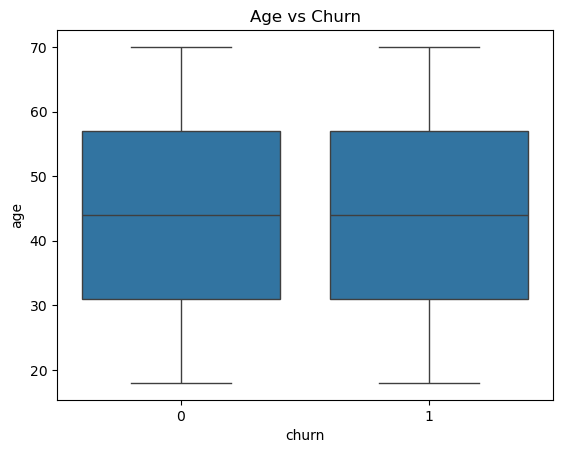

In [17]:
sns.boxplot(x='churn', y='age', data=df)
plt.title('Age vs Churn')
plt.show()

**b) Income vs Churn**

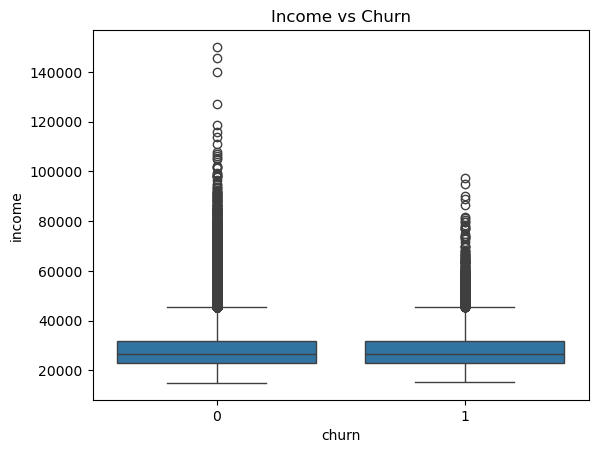

In [20]:
sns.boxplot(x='churn', y='income', data=df)
plt.title('Income vs Churn')
plt.show()

**c) Gender vs Churn**

In [23]:
pd.crosstab(df['gender'], df['churn'], normalize='index') * 100

churn,0,1
gender,,
Female,93.337469,6.662531
Male,93.214596,6.785404


**Behavioral Features Engineering**

In [34]:
customer_features = df.groupby('customer_id').agg(
    frequency=('order_id', 'count'),
    total_spend=('purchase_amount', 'sum'),
    avg_order_value=('purchase_amount', 'mean'),
    recency_days=('days_since_last_purchase', 'max'),
    churn=('churn', 'max')
).reset_index()

customer_features.head()

,customer_id,frequency,total_spend,avg_order_value,recency_days,churn
0,C001,9,26964,2996.000000,2,0
1,C002,12,32048,2670.666667,13,0
2,C003,8,27630,3453.750000,6,0
3,C004,13,30857,2373.615385,35,0
4,C005,8,20662,2582.750000,12,0


**Correlation Analysis**

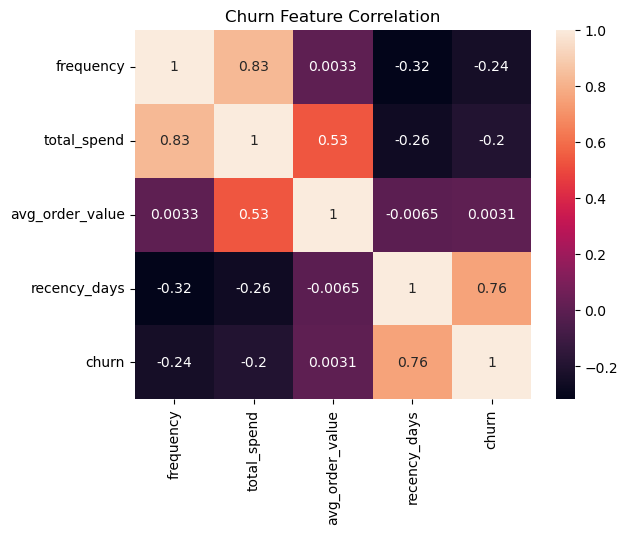

In [37]:
corr = customer_features[['frequency', 'total_spend', 'avg_order_value', 'recency_days', 'churn']].corr()

sns.heatmap(corr, annot=True)
plt.title("Churn Feature Correlation")
plt.show()

**High-Risk Customer Identification**

In [40]:
high_risk = customer_features[
    (customer_features['recency_days'] > 90) & 
    (customer_features['frequency'] < 3)
]

high_risk.head()

,customer_id,frequency,total_spend,avg_order_value,recency_days,churn
1110,C1091,2,4110,2055.0,253,1
1317,C11097,2,7643,3821.5,244,1
1812,C11542,1,3275,3275.0,260,1
2509,C12170,1,1293,1293.0,263,1
2617,C12268,2,8361,4180.5,159,1


**Churn Segmentation**

In [43]:
customer_features['risk_segment'] = pd.cut(
    customer_features['recency_days'],
    bins=[0,30,90,180,500],
    labels=['Active','At Risk','High Risk','Churned']
)

customer_features['risk_segment'].value_counts()

risk_segment
Active       11125
At Risk       7097
High Risk     1628
Churned        150
Name: count, dtype: int64